[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gokulganesan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


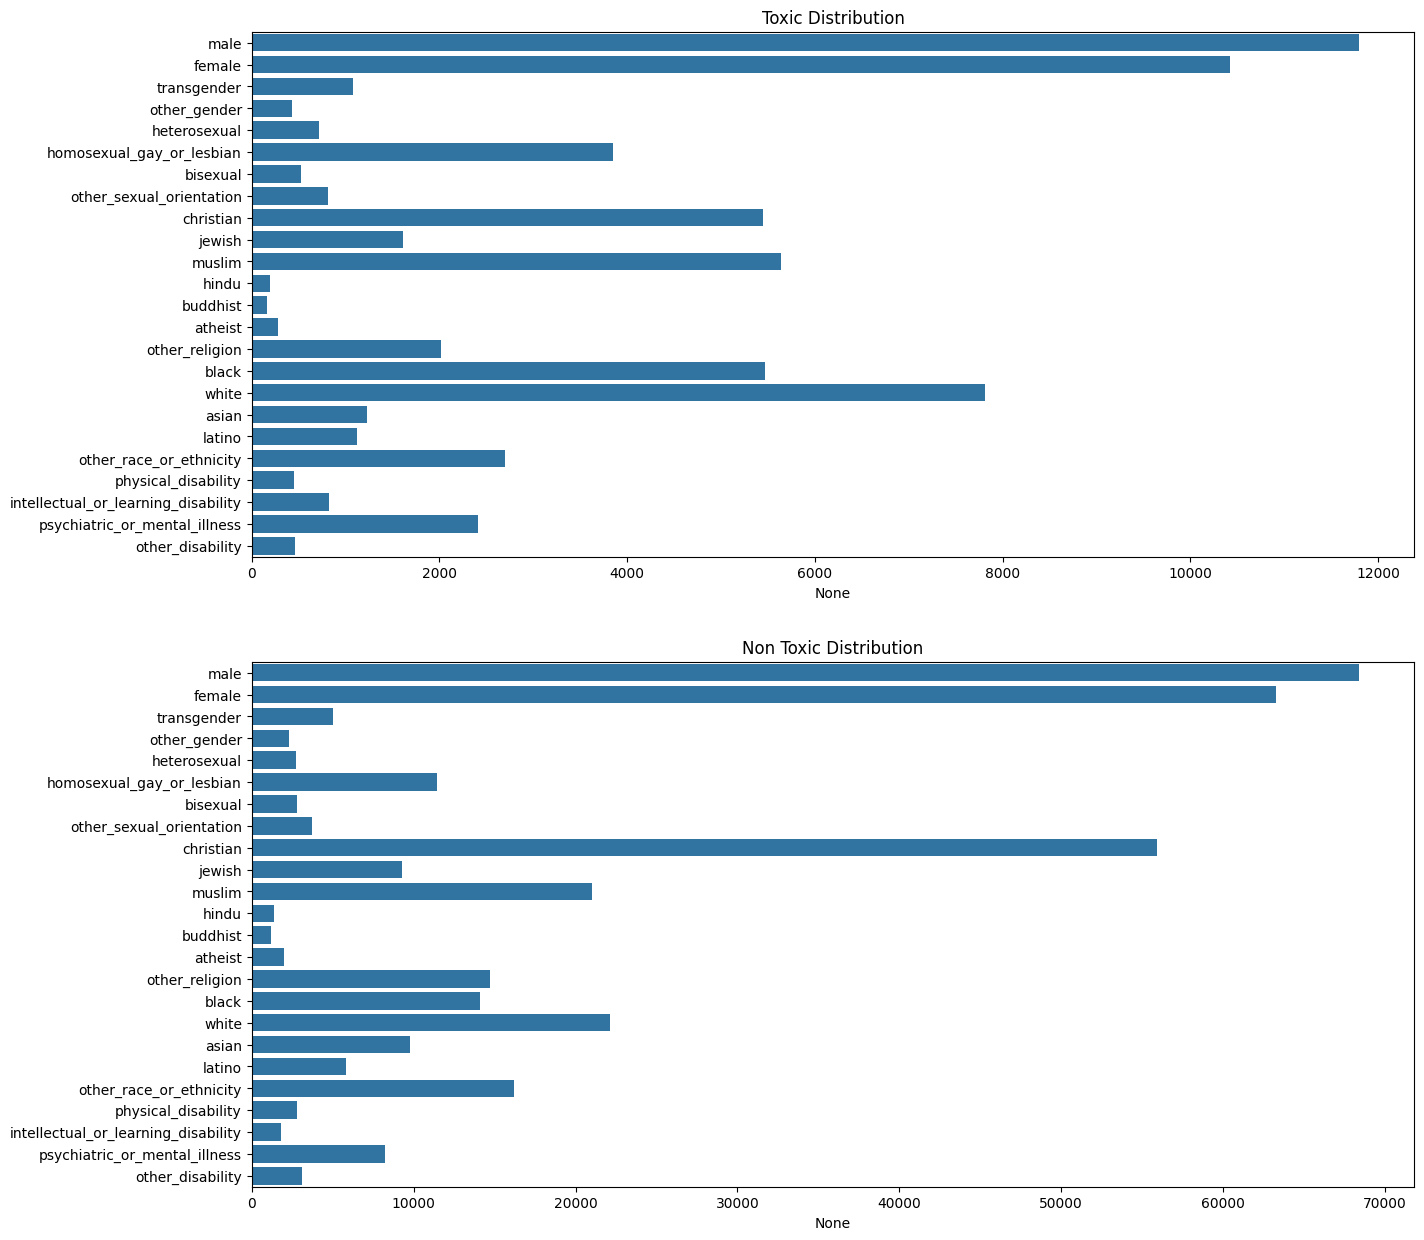

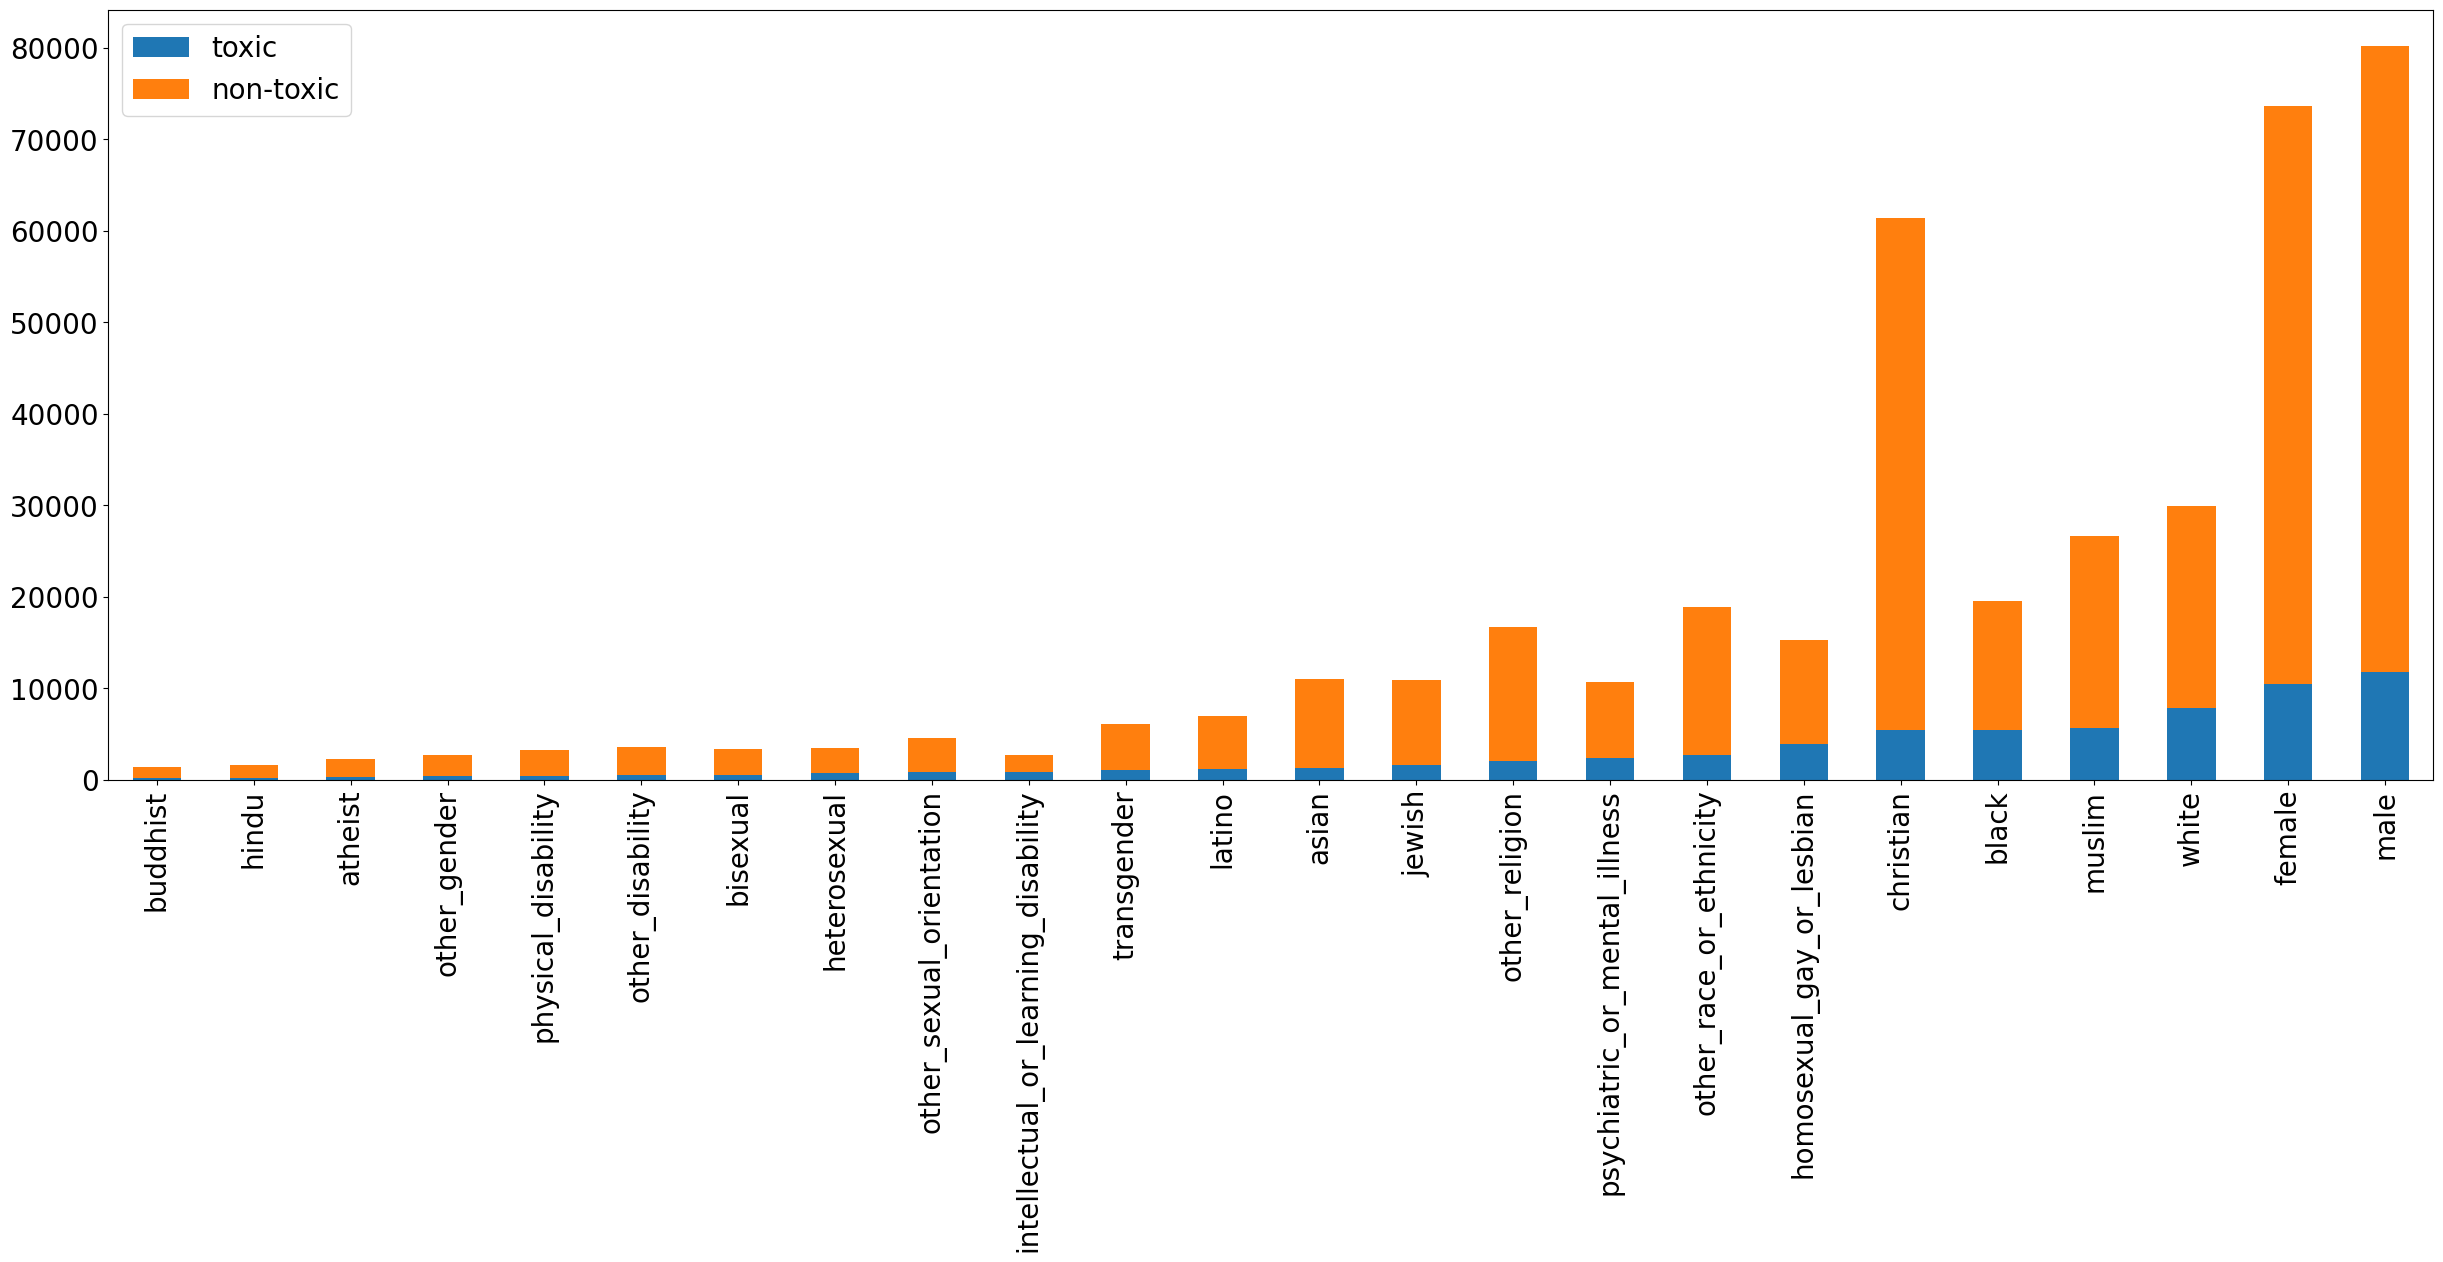

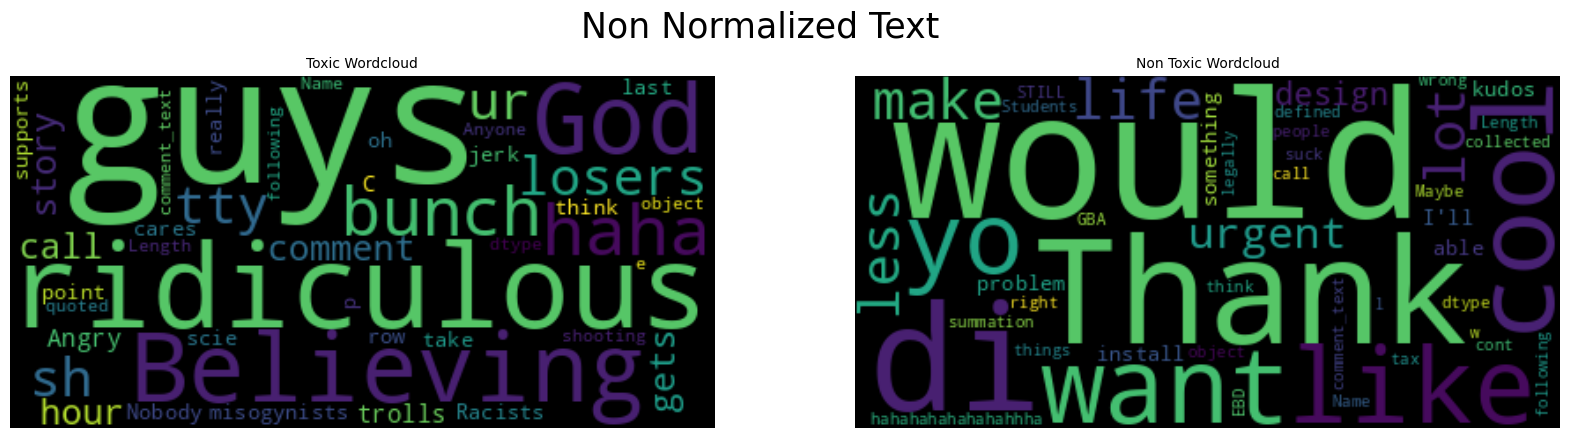

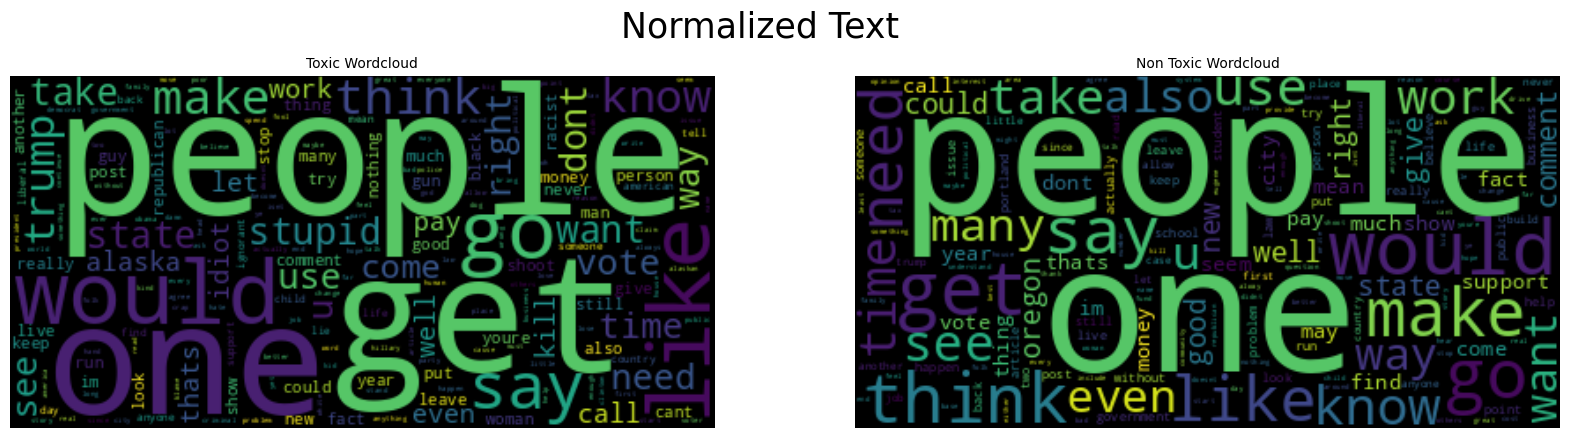

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [13]:
# Basic Pydata Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt     
import seaborn as sns
import html
import unicodedata

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Keras
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from keras.utils import plot_model


# Standard plotly imports
import plotly.offline as py 
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

# nlp
import string
import re    #for regex
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
from wordcloud import WordCloud, STOPWORDS

## warnings
import warnings
warnings.filterwarnings("ignore")


def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()


def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text, and by defult lemmatize nouns"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/test.csv')
train_data.head()


train_data['toxic'] = np.where(train_data['target'] >= .5, 'Toxic', 'Non-Toxic')


# lets create a list of all the identities tagged in this dataset. This list given in the data section of this competition.
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']
# getting the dataframe with identities tagged
train_labeled_df = train_data.loc[:, ['target'] + identities ].dropna()

# lets define toxicity as a comment with a score being equal or .5
toxic_df = train_labeled_df[train_labeled_df['target'] >= .5][identities]
non_toxic_df = train_labeled_df[train_labeled_df['target'] < .5][identities]
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.
toxic_count = toxic_df.apply(lambda x : x > 0 ).sum()
non_toxic_count = non_toxic_df.apply(lambda x : x > 0 ).sum()
fig, ax = plt.subplots(nrows= 2,ncols= 1,figsize=(15,15))

sns.barplot(x= toxic_count, y= identities, ax=ax[0])
sns.barplot(x= non_toxic_count, y= identities, ax=ax[1])

ax[0].set_title("Toxic Distribution")
ax[1].set_title("Non Toxic Distribution")
plt.show()

# now we can concat the two series together to get a toxic count vs non toxic count for each identity
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)

toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20});

word_cloud_non_toxic = train_data[train_data['toxic'] == "Non-Toxic"]['comment_text']
word_cloud_toxic = train_data[train_data['toxic'] == "Toxic"]['comment_text']

wordcloud_non = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(word_cloud_non_toxic))

wordcloud_toxic = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(word_cloud_toxic))

fig = plt.figure(figsize=[20,5])
plt.suptitle('Non Normalized Text', size = 25)

fig.add_subplot(1, 2, 1).set_title("Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_toxic, interpolation="bilinear")
plt.axis("off")

fig.add_subplot(1, 2, 2).set_title("Non Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_non, interpolation="bilinear")
plt.axis("off")

plt.show()

# make lists for normalized text
clean_toxic_text = [normalize_text(sent) for sent in train_data[train_data['toxic'] == "Toxic"]['comment_text'][:10000]]
clean_non_toxic_text = [normalize_text(sent) for sent in train_data[train_data['toxic'] == "Non-Toxic"]['comment_text'][:10000]]
wordcloud_non = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(clean_non_toxic_text))

wordcloud_toxic = WordCloud(
                          background_color='black',
                          stopwords=stop_words,
                          max_words=2000,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(clean_toxic_text))

fig = plt.figure(figsize=[20,5])
plt.suptitle('Normalized Text', size = 25)

fig.add_subplot(1, 2, 1).set_title("Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_toxic, interpolation="bilinear")
plt.axis("off")

fig.add_subplot(1, 2, 2).set_title("Non Toxic Wordcloud", fontsize=10)
plt.imshow(wordcloud_non, interpolation="bilinear")
plt.axis("off")

plt.show()


Vectorize = TfidfVectorizer()
X = Vectorize.fit_transform(train_data["comment_text"])
X_test_date = Vectorize.transform(test_data["comment_text"])

y = np.array(train_data['target'].apply(lambda x: x > .5).astype('int'))

X.shape, y.shape, X_test_date.shape
# spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
# Fitting a simple Logistic Regression on tf-idf
lr = LogisticRegression(C=1.0)
lr.fit(X_train, y_train)
LogisticRegression()
corss_scores = cross_val_score(lr, X, y, cv=5, scoring= 'roc_auc')
corss_scores.mean()
0.9578420411190554
y_pred = lr.predict(X_test)

plt.figure(figsize=(8, 6))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cmap='Reds')
plt.xlabel('predicted value')
plt.ylabel('true value');
print(classification_report(y_test, y_pred))